In [1]:
from collections import defaultdict

import networkx as nx
import numpy as np

import matplotlib.pyplot as plt

# "Simple" Community Detection (CD)

<h3>CD on the LFR Benchmark</h3>
<p>The <strong>LFR benchmark</strong> is a method for generating synthetic networks with a predefined community structure, used to evaluate community detection algorithms.</p>

<p>In this benchmark, the <strong>"mu"</strong> parameter (mixing parameter) controls the ratio of edges a node has with nodes outside its community versus within its community:</p>

<ul>
  <li><strong>Low "mu"</strong> (closer to 0): most edges are within the node's own community, making communities more distinct.</li>
  <li><strong>High "mu"</strong> (closer to 1): more edges are between communities, making them less distinct.</li>
</ul>

<p>Thus, "mu" determines the clarity of community boundaries in the generated network.</p>

In [2]:
from cdlib.benchmark import LFR

n = 500
tau1 = 3
tau2 = 2
mu = 0.1

G, GT_coms = LFR(n, tau1, tau2, mu, average_degree=5, min_community=25)

G.remove_edges_from(nx.selfloop_edges(G))

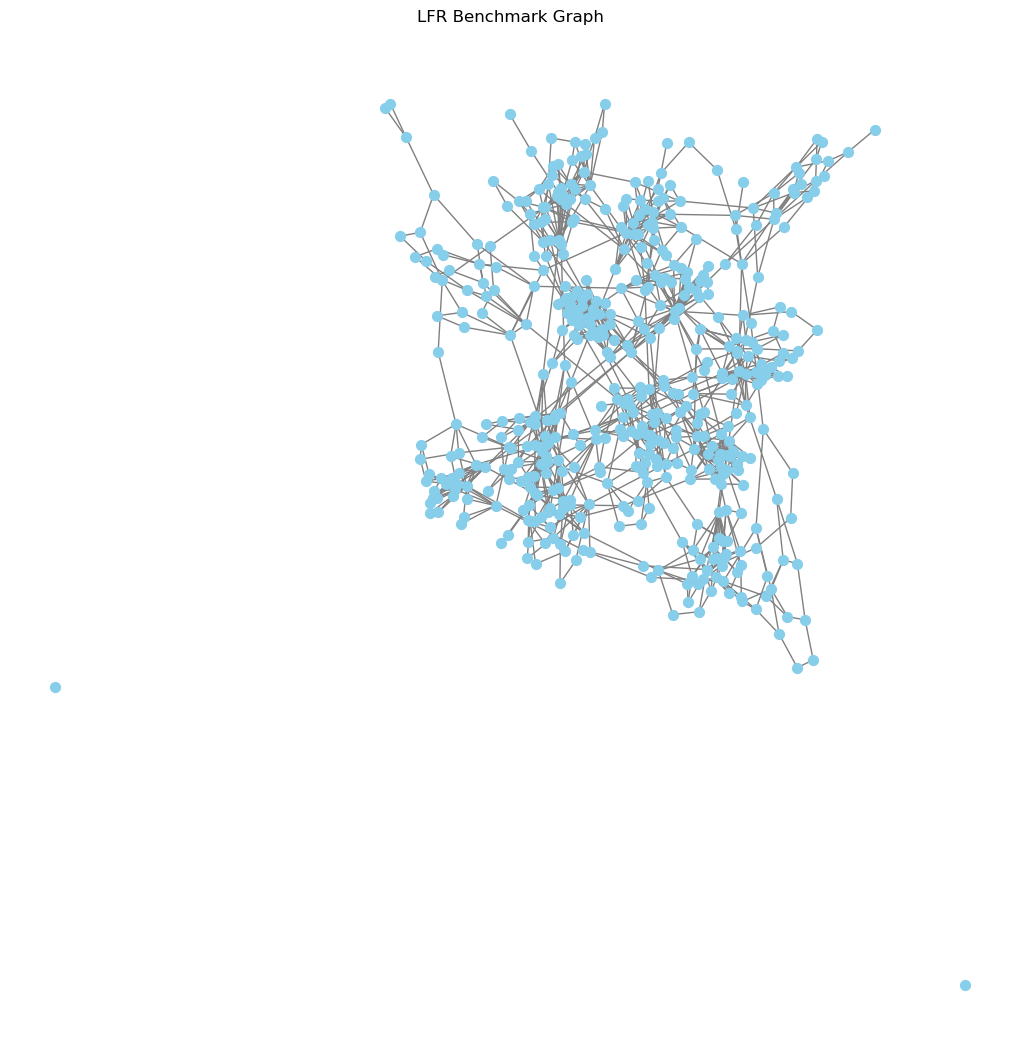

In [3]:
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Position nodes using the spring layout
nx.draw(G, pos, node_size=50, node_color='skyblue', edge_color='gray', with_labels=False)
plt.title("LFR Benchmark Graph")
plt.show()

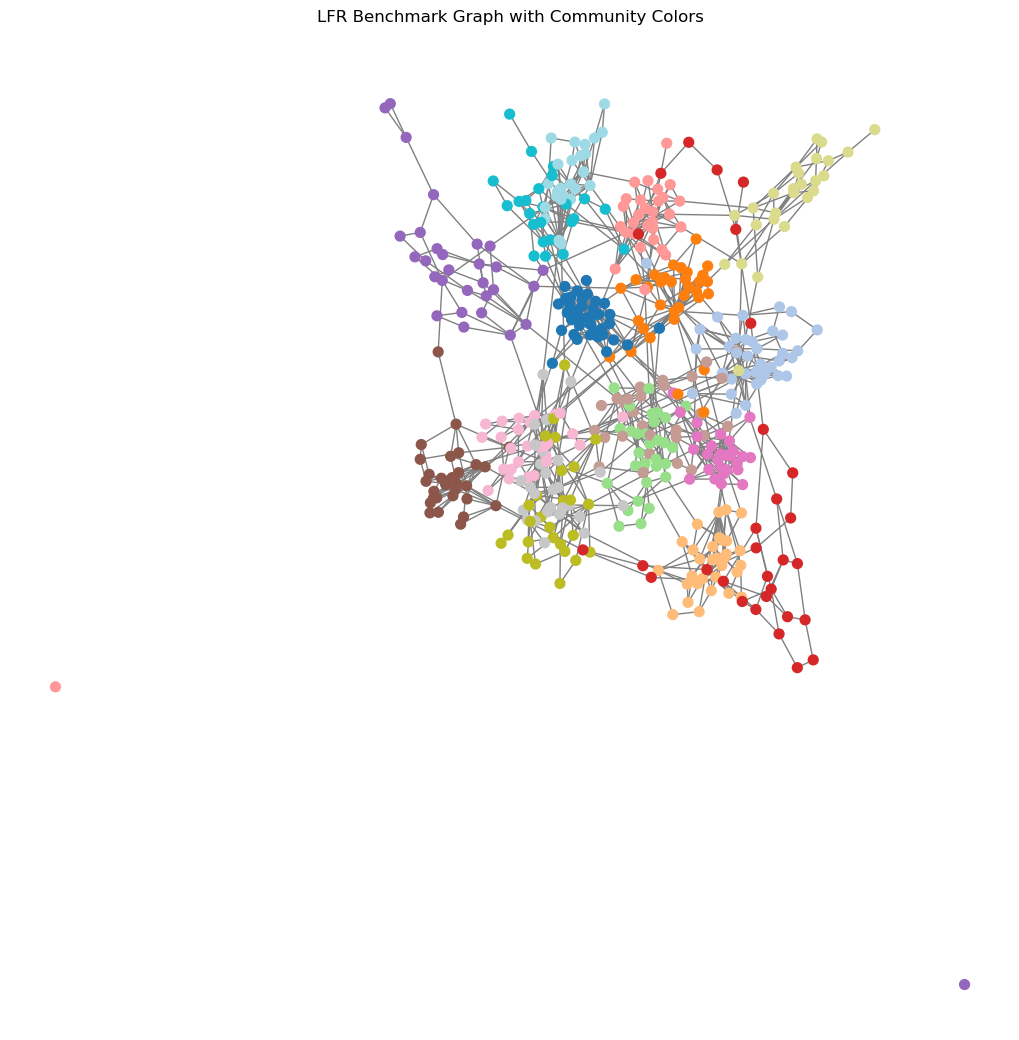

In [4]:
num_communities = len(GT_coms.communities)
colors = plt.cm.tab20(np.linspace(0, 1, num_communities))  # Use a colormap to get distinct colors

# Assign a color to each node based on its community
node_colors = {}
for i, community in enumerate(GT_coms.communities):
    for node in community:
        node_colors[node] = colors[i]

# Extract colors in the same order as the nodes in G
node_color_list = [node_colors[node] for node in G.nodes()]

# Plot the graph with community-based coloring
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)  # Position nodes using the spring layout
nx.draw(G, pos, node_size=50, node_color=node_color_list, edge_color='gray', with_labels=False)
plt.title("LFR Benchmark Graph with Community Colors")
plt.show()

In [5]:
from cdlib.algorithms import louvain

coms = louvain(G) # CD

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool', 'bayanpy', 'infomap', 'wurlitzer'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer'}


In [6]:
len( coms.communities )

19

In [7]:
len( GT_coms.communities )

17

In [8]:
from cdlib import evaluation

mod = evaluation.newman_girvan_modularity(G, coms)
mod.score

0.8658359794072242

In [9]:
ari = evaluation.adjusted_rand_index(GT_coms, coms)
ari.score

0.9695252101019959

# Attributed Community Detection (ACD)

<h3>ACD on the XMark Benchmark</h3>
<p>The <strong>XMark benchmark</strong> extends the LFR benchmark by introducing additional parameters for generating synthetic node-attributed networks with community structures, enhancing the evaluation of community detection algorithms.</p>

<p>In addition to the <strong>"mu"</strong> parameter, which controls the ratio of edges a node has with nodes outside its community versus within its community, XMark introduces the <strong>"theta"</strong> parameter:</p>

<ul>
  <li><strong>"mu"</strong> (mixing parameter):</li>
  <ul>
    <li><strong>Low "mu"</strong> (closer to 0): most edges are within the node's own community, leading to more distinct communities.</li>
    <li><strong>High "mu"</strong> (closer to 1): more edges are between communities, resulting in less distinct communities.</li>
  </ul>
  
  <li><strong>"theta"</strong> (noise parameter):</li>
  <ul>
    <li><strong>High "theta"</strong>: indicates high dissimilarity or heterogeneity within communities, leading to a more noisy community in terms of node attributes.</li>
    <li><strong>Low "theta"</strong>: indicates high homogeneity or homophily within communities, resulting in more cohesive groups in terms of node attributes.</li>
  </ul>
</ul>

<p>Thus, the combination of "mu" and "theta" in the XMark benchmark allows for a more controlled scenario over community structure and attribute noise within them.</p>

In [10]:
from cdlib.benchmark import XMark

n = 500
tau1 = 3
tau2 = 2
m_cat = [2, 3]

mu = 0.3
theta = 0.05

G_attr, GT_attr_coms = XMark(n=n, gamma=tau1, beta=tau2, mu=mu,
                          m_cat=m_cat,
                          theta=theta,
                          avg_k=5, min_com=25,
                          type_attr="categorical")


for node in G_attr.nodes():
    if 'community' in G_attr.nodes[node]:
        del G_attr.nodes[node]['community']

In [11]:
G_attr.nodes[0]

{'label_0': 1, 'label_1': 2}

In [12]:
coms_simple = louvain(G_attr) # CD

In [13]:
mod = evaluation.newman_girvan_modularity(G_attr, coms_simple)
mod.score

0.5818900116219009

In [14]:
ari = evaluation.adjusted_rand_index(GT_attr_coms, coms_simple)
ari.score

0.1914309402046403

# Simultaneus Fusion

In [15]:
from cdlib.algorithms import eva

attr1 = nx.get_node_attributes(G_attr, 'label_0')
attr2 = nx.get_node_attributes(G_attr, 'label_0')

attrs = {}
for node in G_attr.nodes():
    attrs[node]= {'label_0': attr1[node], 'label_1': attr2[node]}

coms_attr = eva(G_attr, attrs, alpha=0.9)

In [16]:
mod = evaluation.newman_girvan_modularity(G_attr, coms_attr)
mod.score

0.5649351289887511

In [17]:
pur = evaluation.purity(coms_attr)
pur.score

0.9669123625482131

In [18]:
ari = evaluation.adjusted_rand_index(GT_attr_coms, coms_attr)
ari.score

0.2964675209663464

# Early Fusion 

<h3>Weight-based</h3>

A node-attributed graph is transformed into a <b>weighted graph</b>, then standard community detection algorithms on weighted graphs are used.

<b>First Step</b>: Define a structural measure of similarity;

In [19]:
def jaccard(g, u, v):
     
    n_u = set(g.neighbors(u))
    n_v = set(g.neighbors(v))
    cm = len(n_u & n_v)
    
    if len(n_u | n_v) == 0:
        return 0
    
    j = cm / len(n_u | n_v)
    
    return j

<b>Second Step</b>: Define an attribute measure of similarity;

In [20]:
def attribute_similarity(g, u, v):

    u_data = g.nodes[u]
    v_data = g.nodes[v]

    if "attr" not in u_data or "attr" not in v_data:
        return 0
    else:
        a = np.array(u_data["attr"])
        b = np.array(v_data["attr"])

        norm_a = norm(a)
        norm_b = norm(b)

        cos_sim = np.dot(a, b) / (norm_a * norm_b)
        cos_sim = np.clip(cos_sim, -1, 1)
        ang_dist = (2 * np.arccos(cos_sim)) / np.pi
        ang_sim = 1 - ang_dist

        return ang_sim  # angular similarity

<b> Third Step </b>: Linear combination

In [21]:
def similarity(topological, attribute, alpha):

    return alpha * attribute + (1 - alpha) * topological

<b> Fourth Step </b>: Graph Transformation

In [22]:
# Generating a Node-Attributed Graph
n = 500
tau1 = 3
tau2 = 1.5
m_cat = [2, 3]

mu = 0.3
theta = 0.1

G_attr, GT_attr_coms = XMark(n=n, gamma=tau1, beta=tau2, mu=mu,
                          m_cat=m_cat,
                          theta=theta,
                          avg_k=5, min_com=20,
                          type_attr="categorical")

for node in G_attr.nodes():
    if 'community' in G_attr.nodes[node]:
        del G_attr.nodes[node]['community']

In [23]:
G_attr.nodes[0]

{'label_0': 1, 'label_1': 1}

In [24]:
lab1 = nx.get_node_attributes(G_attr, 'label_0')
lab2 = nx.get_node_attributes(G_attr, 'label_1')    

Necessary Step for Pre-Processing Node Attributes

In [25]:
from sklearn.preprocessing import OneHotEncoder
from numpy.linalg import norm
def manage_attributes(g, lab1, lab2):

    attrs = []
    for lab in [lab1, lab2, ]: #lab3]:
        to_encode = [[l] for l in list(lab.values())]
        encoder = OneHotEncoder(sparse=False, dtype=int)
        encoded = encoder.fit_transform(to_encode)
        attrs.append(encoded)

    for i, n in enumerate(g.nodes()):
        vect = []
        for at in attrs:
            new_at = list(at[i])
            vect.extend(new_at)
        g.nodes[n]['attr'] = vect

    for n in g.nodes():
        del g.nodes[n]['label_0']
        del g.nodes[n]['label_1']

In [26]:
manage_attributes(G_attr, lab1, lab2)

In [27]:
G_attr.nodes[0]

{'attr': [1, 0, 1, 0, 0]}

Transformation

In [28]:
def weighted_graph (g, alpha=0):

    gw = nx.Graph()
    
    for u, v in g.edges():
        att_sim = attribute_similarity(g, u, v)
        j_uv = jaccard(g, u, v)

        sim = similarity(j_uv, att_sim, alpha)

        if sim > 0: # remove edges with no similarity
            gw.add_edge(u, v, weight=sim)
        else:
            if u not in gw.nodes():
                gw.add_node(u)
            if v not in gw.nodes():
                gw.add_node(v)

    return gw

In [29]:
alpha = 0.7
G_attr_alpha = weighted_graph(G_attr, alpha=alpha)

In [30]:
G_attr_alpha.nodes[0]

{}

In [31]:
neighs = [n for n in nx.neighbors(G_attr_alpha, 0)]

G_attr_alpha.edges[0, neighs[0]]

{'weight': 0.2606060606060605}

<b> Last Step </b>: Community Detection

In [32]:
from cdlib.algorithms import louvain

coms_simple = louvain(G_attr) # CD

coms_attr = louvain(G_attr_alpha, weight='weight') # Early-fusion CD

In [33]:
ari_simple = evaluation.adjusted_rand_index(GT_attr_coms, coms_simple)
ari_simple.score

0.1207838990122342

In [34]:
ari_attr = evaluation.adjusted_rand_index(GT_attr_coms, coms_attr)
ari_attr.score

0.3274218184297669

<h3>Distance-based</h3>

A node-attributed graph is transformed into a <b>distance/affinity matrix</b>, then standard clustering algorithms are used

<b> First, second, and third steps </b> are used as in the previous example with a weight-based approach

<b> Fourth steph </b>: Graph Transformation

In [35]:
num_nodes = len(G_attr_alpha.nodes())

adj = np.zeros((num_nodes, num_nodes), dtype=float)
for u, v in G_attr_alpha.edges():
    if u == v:
        adj[u][v] = 1
    else:
        adj[u][v] = G_attr_alpha.edges[u,v]['weight'] 
        adj[v][u] = G_attr_alpha.edges[u,v]['weight'] #undirected

dist = 1-adj # dist matrix

In [36]:
adj[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.69999999,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [37]:
dist[0]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.30000001,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

<b> Last step </b>: Clustering

In [38]:
# clustering on dist or adj, it depends on the algorithm implementation

In [39]:
from sklearn.cluster import SpectralClustering 

# in this implementation, need to specify k=number of communites
clustering = SpectralClustering(len(GT_attr_coms.communities), assign_labels='discretize',
                                            affinity='precomputed'
                                # we will use 'adj'
            #                                affinity='precomputed_nearest_neighbors' # we will use 'dist'
                                    )

clustering.fit(adj)

SpectralClustering(affinity='precomputed', assign_labels='discretize',
                   n_clusters=18)

In [40]:
# some pre-processing needed

coms_attr = defaultdict(list)
singletons = []
for i, l in enumerate(clustering.labels_):
    if l == -1: #if dbscan
        singletons.append([i])
    else:
        coms_attr[l].append(i)
        
coms_attr = list(coms_attr.values())

if len(singletons)>1:
    coms_attr = coms_attr + singletons
    
from cdlib import NodeClustering
attr_clust = NodeClustering(communities=coms_attr, graph=G_attr, overlap=False)

In [41]:
ari_attr = evaluation.adjusted_rand_index(GT_attr_coms, attr_clust)
ari_attr.score

0.28136565198606883

<h3> Baseline for Distance-Based approaches </h3>

Using only attributes

In [42]:
G_attr.nodes[0]

{'attr': [1, 0, 1, 0, 0]}

In [43]:
X = []
for k, v in lab1.items():
    label = [v,lab2[k]]
    X.append(label)
    
X = np.array(X)

In [44]:
X[0]

array([1, 1])

In [45]:
from sklearn.cluster import SpectralClustering 

# in this implementation, need to specify k=number of communites
clustering = SpectralClustering(len(GT_attr_coms.communities), assign_labels='discretize')

clustering.fit(X)

SpectralClustering(assign_labels='discretize', n_clusters=18)

In [46]:
coms_attr = defaultdict(list)
singletons = []
for i, l in enumerate(clustering.labels_):
    if l == -1: #if DBSCAN
        singletons.append([i])
    else:
        coms_attr[l].append(i)
        
coms_attr = list(coms_attr.values())

if len(singletons)>1:
    coms_attr = coms_attr + singletons
    
from cdlib import NodeClustering
attr_clust = NodeClustering(communities=coms_attr, graph=G_attr, overlap=False)

In [47]:
ari_attr = evaluation.adjusted_rand_index(GT_attr_coms, attr_clust)
ari_attr.score

0.31606438065333436